In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import math
from skimage.draw import line

from coppeliasim_zmqremoteapi_client import RemoteAPIClient 


In [2]:
# Definindo o grid

map_size = 12.0 # Lado de 12 metros
grid_resolution = 0.05 
grid_dimension = int(map_size/grid_resolution)

grid = np.full((grid_dimension, grid_dimension), 0.0)

# Converter coordenadas da cena para o grid
map_offset = map_size/2
def world_to_grid(world_x, world_y):
    grid_x = int((world_x + map_offset) / grid_resolution)
    grid_y = int((world_y + map_offset) / grid_resolution)

    return grid_x, grid_y


# Transforma o grid de log odss para probabilidade normal
def log_odds_to_prob(log_odds_grid):
    odds = np.exp(log_odds_grid)
    return odds / (1.0 + odds)

# Plota o grid
def plot_grid(grid):
    fig = plt.figure(figsize=(8,8), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')
    plt.imshow(grid, cmap='Greys', origin='lower')
    ax.set_xticks(np.arange(0, grid_dimension, 1))
    ax.set_yticks(np.arange(0, grid_dimension, 1))

    plt.colorbar()

In [3]:
# Classe modificada pelo Iago

class HokuyoSensorSim(object):
    """
    Simulates a Hokuyo laser sensor in CoppeliaSim using vision sensors.

    This class provides an interface to interact with a simulated Hokuyo sensor,
    typically attached to a robot in CoppeliaSim. It manages the underlying vision
    sensors and provides a method to retrieve sensor data in range format.

    Attributes:
        _sim: The simulation API object used to interact with CoppeliaSim.
        _base_name (str): The name of the base object to which the Hokuyo sensor is attached.
        _is_range_data (bool): Determines if sensor data is returned as range values (True).
        _base_obj: The handle of the base object in the simulation.
        _vision_sensors_obj (list): Handles of the vision sensors used to simulate the Hokuyo sensor.
        _angles_lua (np.array): Stores the precise angles read from the simulation.
        _is_initialized_angles (bool): Indicates if the angles were read successfully.
    
    Args:
        sim: The simulation API object.
        base_name (str): The name of the base object (must contain 'fastHokuyo').
        is_range_data (bool, optional): If True, sensor data is returned as range values. Defaults to True.
        
    Raises:
        ValueError: If 'fastHokuyo' is not in the base_name, or if the base object or vision sensors are not found.

    Methods:
        get_is_range_data() -> bool:
            Returns whether sensor data is returned as range values.

        set_is_range_data(is_range_data: bool) -> None:
            Sets whether sensor data should be returned as range values.

        getSensorData():
            Retrieves sensor data from the vision sensors.
            Returns a list of [angle, range] values.
    """
    
    _sim = None
    
    _base_name = "" 

    _angles_lua = np.empty(0) 
    _is_initialized_angles = False 
    ANGLE_SIGNAL = 'signal.hokuyo_angle_data'
    
    _base_obj = None 
    _is_range_data = True
    _vision_sensors_obj = []

    def __init__(self, sim, base_name, is_range_data=True):
        self._sim = sim
        self._base_name = base_name
        self._is_range_data = is_range_data

        if "fastHokuyo" not in base_name:
            raise ValueError(
                f"ERR: fastHokuyo must be in the base object name. Ex: `/kobuki/fastHokuyo`"
            )

        self._base_obj = sim.getObject(base_name)
        if self._base_obj == -1:
            raise ValueError(
                f"ERR: base_obj ({self._base_obj}) is not a valid name in the simulation"
            )

        self._vision_sensors_obj = [
            sim.getObject(f'{base_name}/fastHokuyo_sensor1'),
            sim.getObject(f'{base_name}/fastHokuyo_sensor2'),
        ]

        if any(obj == -1 for obj in self._vision_sensors_obj):
            raise ValueError(
                f"ERR: the _vision_sensors_obj names are not valid in the simulation"
            )

    def get_is_range_data(self) -> bool:
        return self._is_range_data

    def set_is_range_data(self, is_range_data: bool) -> None:
        self._is_range_data = is_range_data

    def _initialize_angles_from_lua(self):

        # Essas variáveis agora são utilizadas apenas quando os valores do laser 
        # não são desempacotados diretamente do sensor, como um fallback em caso de falha
        angle_min = -120 * math.pi / 180
        angle_increment = (240 / 684) * math.pi / 180
        total_steps = 684
        
        for i in range(15):
            try:
                if self._vision_sensors_obj and self._vision_sensors_obj[0] != -1:
                    self._sim.readVisionSensor(self._vision_sensors_obj[0]) 

                angles_packed = self._sim.getBufferProperty(self._sim.handle_scene, self.ANGLE_SIGNAL, {'noError' : True})
                
                if angles_packed:
                    self._angles_lua = np.array(self._sim.unpackFloatTable(angles_packed))
                    self._is_initialized_angles = True
                    print(f"Precise sensor angles read on attempt {i+1} ({self._angles_lua.size} laser beam readings)")
                    return True

                self._sim.step()
                time.sleep(0.01)

            except Exception as e:
                pass 
                
        self._angles_lua = np.arange(angle_min, angle_min + total_steps * angle_increment, angle_increment)
        self._is_initialized_angles = True
        print("ALERT: Communication via buffer property failed. Using approximation. Map may be blurred.")
        return False

    def getSensorData(self):
        
        if not self._is_initialized_angles:
            self._initialize_angles_from_lua()
        
        sensor_data = []
        angle_idx = 0
        angles_to_use = self._angles_lua
        
        if angles_to_use.size == 0:
            return np.empty((0, 2))
        
        for vision_sensor in self._vision_sensors_obj:
            
            result = self._sim.readVisionSensor(vision_sensor)
            if not isinstance(result, (list, tuple)) or len(result) != 3: continue 
                
            r, t, u = result
            if u:
                for j in range(int(u[1])): 
                    for k in range(int(u[0])): 
                        w_idx = 2 + 4 * (j * int(u[0]) + k)
                        v_dist = u[w_idx + 3] 
                        if angle_idx < angles_to_use.size:
                            current_angle = angles_to_use[angle_idx]
                            sensor_data.append([current_angle, v_dist])
                            angle_idx += 1
                        else:
                            break 
                    if angle_idx >= angles_to_use.size: break

        return np.array(sensor_data) if sensor_data else np.empty((0, 2))

In [4]:
try:
    # Connect to the CoppeliaSim server
    client = RemoteAPIClient()
    sim = client.require("sim")
    sim.setStepping(True)

    # Handle para o ROBÔ
    robotname = 'kobuki'
    robotHandle = sim.getObject('/' + robotname)

    # Handle para as juntas das RODAS
    r_wheel = sim.getObject('/' + robotname + '/' + robotname + '_rightMotor')
    l_wheel = sim.getObject('/' + robotname + '/' + robotname + '_leftMotor')

    # Handle para o sensor
    lidar_handle = sim.getObject('/' + robotname + '/fastHokuyo')
    hokuyo_sensor = HokuyoSensorSim(sim, "/"+ robotname +"/fastHokuyo")

    # Constantes para usar log-odds:
    
    prob_occ_hit = 0.85 # Probabilidade de célula estar ocupada dado que sensor identificou algo
    prob_occ_miss = 0.20 # Probabilidade de célula estar ocupada dado que sensor não identificou algo

    log_odds_occ = np.log(prob_occ_hit / (1.0 - prob_occ_hit))     # Valor positivo
    log_odds_free = np.log(prob_occ_miss / (1.0 - prob_occ_miss))  # Valor negativo

    log_odds_max = 5.0
    log_odds_min = -5.0
    
    

    # Lembrar de habilitar o 'Real-time mode'    
    # Parar a simulação se estiver executando
    initial_sim_state = sim.getSimulationState()
    if initial_sim_state != 0:
        sim.stopSimulation()
        time.sleep(1)
    
    # Inicia a simulação
    sim.startSimulation()
    sim.step()
    following = False
    print("Starting robot control loop...")
    # Histórico completo de posições
    if not hasattr(sim, "_traj"):
        sim._traj = []

    lidar_points_x = []
    lidar_points_y = []


    while (sim_time := sim.getSimulationTime()) <= 240:
        print(f"Simulation time: {sim_time:.2f} [s]")
        sim.step()
        dt = sim.getSimulationTimeStep()


        # Leitura dos dados do sensor
        sensor_data = hokuyo_sensor.getSensorData()

        
        if len(sensor_data) > 0:
            lidar_pos = sim.getObjectPosition(lidar_handle, -1)
            lidar_orientation = sim.getObjectOrientation(lidar_handle, -1) 
            lidar_theta = lidar_orientation[2] # Rotação em Z
            lidar_gx, lidar_gy = world_to_grid(lidar_pos[0], lidar_pos[1])
            
            matrix_lidar_to_world = sim.getObjectMatrix(lidar_handle, -1)
            transformation_matrix = np.eye(4)
            transformation_matrix[0:3, 0:4] = np.array(matrix_lidar_to_world).reshape(3, 4)
            
            # Atualizar o grid
            for i in range(len(sensor_data)):
            
                local_angle = sensor_data[i, 0] + np.random.uniform(-0.001, 0.001)
                r = sensor_data[i, 1] + np.random.uniform(-0.001, 0.001)          

                p_local_x = r * np.cos(local_angle)
                p_local_y = r * np.sin(local_angle)
                local_point = np.array([p_local_x, p_local_y, 0, 1])
                global_point = transformation_matrix @ local_point
                global_point = global_point[:2]
                
                point_gx, point_gy = world_to_grid(global_point[0], global_point[1])
                
                rr, cc = line(lidar_gy, lidar_gx, point_gy, point_gx)

                if r < (5.0 - 0.01):   # Garantir que não marca como ocupado quando o sensor não identifica nada
                    if len(rr) > 0:
                        grid[rr[:-1], cc[:-1]] += log_odds_free
                
                    grid[point_gy, point_gx] += log_odds_occ

                else:
                    if len(rr) > 0:
                        grid[rr, cc] += log_odds_free

                # Limitar os valores dos log odds
                if len(rr) > 0:
                    grid[rr, cc] = np.clip(grid[rr, cc], log_odds_min, log_odds_max)
                grid[point_gy, point_gx] = np.clip(grid[point_gy, point_gx], log_odds_min, log_odds_max)

        prob_map = 1 - 1 / (1 + np.exp(grid))

        
        # Salvar trajetoria
        pos = sim.getObjectPosition(robotHandle, -1)
        x, y = pos[0], pos[1]
        sim._traj.append((x, y))


        stuck_turn = False
        if len(sim._traj) > 10:
            x_old, y_old = sim._traj[-10]   # posição exata de 10 passos atrás
            dist_diff = np.linalg.norm([x - x_old, y - y_old])
        
            # limiar pequeno 
            if dist_diff < 0.015:  
                stuck_turn = True

        # IMPLEMENTAR A MOVIMENTAÇÃO DO ROBO
        if len(sensor_data) > 0:
                ang = sensor_data[:, 0]
                dist = sensor_data[:, 1]
            
                front_lim = np.deg2rad(40)
                side_min = np.deg2rad(45)
                side_max = np.deg2rad(85)
            
                front_mask = np.abs(ang) <= front_lim
                right_mask = (ang < -side_min) & (ang > -side_max)
                left_mask  = (ang > side_min) & (ang < side_max)
            
                d_front = np.min(dist[front_mask]) if np.any(front_mask) else np.inf
                d_right = np.min(dist[right_mask]) if np.any(right_mask) else np.inf
                d_left  = np.min(dist[left_mask])  if np.any(left_mask)  else np.inf
            
                stop_dist = 0.25
                if d_front < stop_dist or d_left < 0.12 or d_right < 0.12:
                    v = 0.0
                    w = np.deg2rad(90)
                else:
                    v_max = 0.18
                    w_base = 0.05
                    w_max = 0.9
                    infl = 0.95
            
                    v = v_max * min(1.0, d_front / infl)
            
                    w_rep = 0.0
            
                    def repel(d, direction):
                        if not np.isfinite(d) or d <= 0:
                            return 0.0
                        g = 1.0
                        val = g * (1.0 / d - 1.0 / infl)
                        if val < 0:
                            return 0.0
                        return val * direction
            
                    w_rep += repel(d_left, -1.0)
                    w_rep += repel(d_right, +1.0)
            
                    if d_front < infl:
                        if d_right > d_left:
                            w_rep += repel(d_front, +1.0) * 0.7
                        else:
                            w_rep += repel(d_front, -1.0) * 0.7
            
                    w = w_base + w_rep
                    w = np.clip(w, -w_max, w_max)
            
                    try:
                        if not hasattr(sim, "_last_turn"):
                            sim._last_turn = sim.getSimulationTime()
                        dt_turn = sim.getSimulationTime() - sim._last_turn
                        if dt_turn > 6.0:
                            w += np.deg2rad(25)
                            sim._last_turn = sim.getSimulationTime()
                    except:
                        pass
            
                L = 0.23
                R = 0.035
                w_r = ((2.0 * v) + (w * L)) / (2.0 * R)
                w_l = ((2.0 * v) - (w * L)) / (2.0 * R)
            
                max_wheel = 20.0
                w_l = np.clip(w_l, -max_wheel, max_wheel)
                w_r = np.clip(w_r, -max_wheel, max_wheel)
            
                sim.setJointTargetVelocity(l_wheel, w_l)
                sim.setJointTargetVelocity(r_wheel, w_r)






    # Parando o robô
    print("Stopping robot...")
    sim.setJointTargetVelocity(l_wheel, 0)
    sim.setJointTargetVelocity(r_wheel, 0)
    
except Exception as e:
    print(f"An error occurred: {e}")
    
# Parando a simulação
sim.stopSimulation()

print('Program ended')
    

Starting robot control loop...
Simulation time: 0.05 [s]
Precise sensor angles read on attempt 1 (684 laser beam readings)
Simulation time: 0.10 [s]
Simulation time: 0.15 [s]
Simulation time: 0.20 [s]
Simulation time: 0.25 [s]
Simulation time: 0.30 [s]
Simulation time: 0.35 [s]
Simulation time: 0.40 [s]
Simulation time: 0.45 [s]
Simulation time: 0.50 [s]
Simulation time: 0.55 [s]
Simulation time: 0.60 [s]
Simulation time: 0.65 [s]
Simulation time: 0.70 [s]
Simulation time: 0.75 [s]
Simulation time: 0.80 [s]
Simulation time: 0.85 [s]
Simulation time: 0.90 [s]
Simulation time: 0.95 [s]
Simulation time: 1.00 [s]
Simulation time: 1.05 [s]
Simulation time: 1.10 [s]
Simulation time: 1.15 [s]
Simulation time: 1.20 [s]
Simulation time: 1.25 [s]
Simulation time: 1.30 [s]
Simulation time: 1.35 [s]
Simulation time: 1.40 [s]
Simulation time: 1.45 [s]
Simulation time: 1.50 [s]
Simulation time: 1.55 [s]
Simulation time: 1.60 [s]
Simulation time: 1.65 [s]
Simulation time: 1.70 [s]
Simulation time: 1.

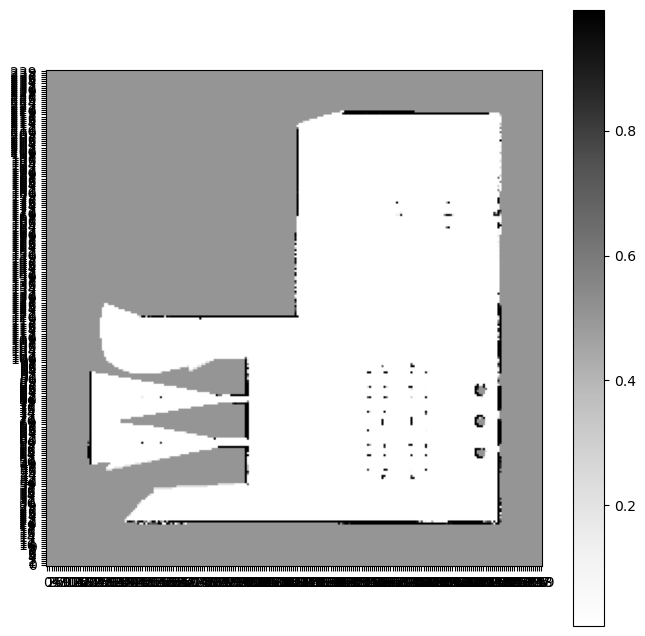

In [5]:
grid = log_odds_to_prob(grid)
plot_grid(grid)

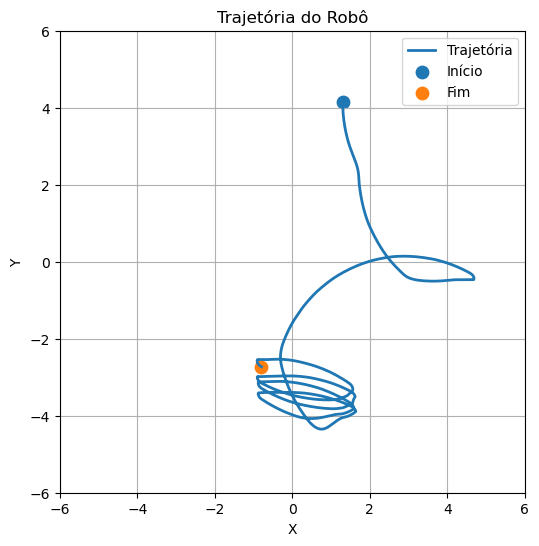

In [6]:
traj = np.array(sim._traj)
xs = traj[:, 0]
ys = traj[:, 1]

plt.figure(figsize=(6, 6))
plt.plot(xs, ys, linewidth=2, label="Trajetória")
plt.scatter(xs[0], ys[0], s=80, label="Início")
plt.scatter(xs[-1], ys[-1], s=80, label="Fim")
plt.title("Trajetória do Robô")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.legend()
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.show()
